In [67]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
#from visualization14 import ANN
#%matplotlib widget

In [68]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
from collections import Counter
# Visualization
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import copy

In [69]:
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data
from torchvision.transforms import ToTensor
from torchvision.models import resnet18,resnet50
from torch import nn
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.metrics.functional import accuracy
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

## For trained weights

In [70]:
from torchvision import models
original_model = models.resnet18(pretrained=True)
#original_model.g
#original_model=models.alexnet(pretrained=True)
class ResNetMNIST(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = resnet18(num_classes=10)
        self.model.weight='IMAGENET1K_V1'
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.loss = nn.CrossEntropyLoss()
        self.features = nn.Sequential(
                        # stop at conv4   get_features()
                      torch.nn.Sequential(*list(self.model.children())[:-1])# *list(original_model.features.children())[:-1]
                    )

    @auto_move_data
    def forward(self, x):
        return self.model(x),self.model(x)#torch.softmax(model(x), dim=1)

    def training_step(self, batch, batch_no):
        x, y = batch
        #print(x.size())
        _,logits = self(x)
        loss = self.loss(logits, y)
        return loss
    def validation_step(self, batch, batch_no):
        x, y = batch
        #print(x.size())
        _,logits = self(x)
        loss = self.loss(logits, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0005)#RMSprop

In [71]:
#orig_model = ResNetMNIST()
model = ResNetMNIST()

In [72]:
trainer = pl.Trainer(
    #gpus=1,
    max_epochs=100,
    progress_bar_refresh_rate=20
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


# Select Randomly 200 points to start AL training 

In [73]:
import time
start_time = time.time()
if __name__ == "__main__":
    
    data_dir='./'
    # download
    MNIST(data_dir, train=True, download=True)
    MNIST(data_dir, train=False, download=True)
    transform = transforms.Compose([transforms.ToTensor()])
    dataset_full = MNIST(data_dir,train=True,transform=transform)
    dataset_train = MNIST(data_dir,train=True,transform=transform)
            
    #print(type(dataset_full),len(dataset_full)) 
    dataset_train, dataset_val,remaining = random_split(dataset_full, [200,0,59800])
    #print(len(dataset_train),type(dataset_train))
    dataset_train_original=copy.deepcopy(dataset_train)
    train_dl = DataLoader(dataset_train, batch_size=8, shuffle=True)
    #valid_dl = DataLoader(dataset_val, batch_size=64, shuffle=True)

    trainer.fit(model,train_dl)#,val_dataloaders=valid_dl)
Resnet_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\USER\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name     | Type             | Params
----------------------------------------------
0 | model    | ResNet           | 11.2 M
1 | loss     | CrossEntropyLoss | 0     
2 | features | Sequential       | 11.2 M
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

--- 1964.6813123226166 seconds ---


## Shows some of MNIST data

In [74]:
import itertools
batch_size = 2
sample_at = 5
k = int(np.floor(sample_at/batch_size))

tensor([5, 6, 0, 8, 6, 0, 6, 4, 4, 8, 5, 5, 6, 9, 0, 7, 5, 8, 2, 6, 5, 0, 7, 8,
        8, 9, 4, 0, 2, 4, 9, 9])


C:\Users\USER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
C:\Users\USER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


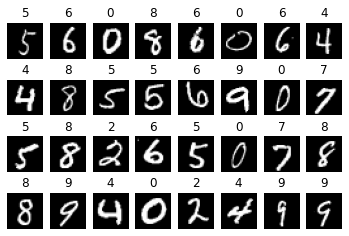

In [75]:
import itertools
k = int(np.floor(sample_at/batch_size))
transform = transforms.Compose([transforms.ToTensor()])
#data = MNIST(".", train=False, download=True, transform=transform)
data=copy.deepcopy(dataset_train)
dataloader = DataLoader(data, batch_size=32)
my_sample = next(itertools.islice(dataloader, k, None))
print (my_sample[1])

plt.figure()
for i in range(32):
    plt.subplot(4,8,i+1)
    arr=np.squeeze(data)
    plt.imshow(my_sample[0][i][0], cmap='gray')
    plt.axis('off')
    plt.title(my_sample[1][i].item())

#dataloader = DataLoader(data, batch_size=32)

## prepare_test_embeddings

In [76]:
def prepare_test_embeddings(data):
    #model=my_model
    #transform = transforms.Compose([transforms.ToTensor()])
    #data=dataset_train
    dataloader = DataLoader(data, batch_size=32)
    #test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 10), dtype=torch.float32)
    #c=0
    #print(len(dataloader))
    for x,y in dataloader:
     #   print(c)
        #c=c+1
     #   x = x.cpu()
        embeddings, logits = model(x)#orig_model(x)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        test_predictions.extend(predicted_class.detach().cpu().tolist())
        test_targets.extend(y.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        #test_embeddings = torch.cat((test_embeddings, embeddings), 0)
       # test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
        #print('Y',y.detach().cpu().tolist())
    #test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    #print(test_predictions == test_targets)
    test_acc = np.sum(test_predictions == test_targets)
    final_test_acc = test_acc/len(test_embeddings)
    
    return test_embeddings,test_targets,test_predictions,final_test_acc

In [77]:
data_test = MNIST(".", train=False, download=True, transform=transform)
_,_,_,final_test_acc=prepare_test_embeddings(data_test)
print('Initial Testing accuracy:  ',final_test_acc)

Initial Testing accuracy:   0.9043


# Kmeans ++

In [78]:
def all_list(test_embeddings,test_targets,data):
    test_embeddings=test_embeddings
    test_targets=test_targets
    list1,data1=[],[]
    list2,data2=[],[]
    list3,data3=[],[]
    list4,data4=[],[]
    list5,data5=[],[]
    list6,data6=[],[]
    list7,data7=[],[]
    list8,data8=[],[]
    list9,data9=[],[]
    list10,data10=[],[]
    i=0
    for embeddings in test_embeddings:
        if test_targets[i]==0:
            list1.append(embeddings)
            #data1.append(data[i])
        if test_targets[i]==1:
            list2.append(embeddings)
            #data2.append(data[i])
        if test_targets[i]==2:
            list3.append(embeddings)
            #data3.append(data[i])
        if test_targets[i]==3:
            list4.append(embeddings)
            #data4.append(data[i])
        if test_targets[i]==4:
            list5.append(embeddings)
            #data5.append(data[i])
        if test_targets[i]==5:
            list6.append(embeddings)
            #data6.append(data[i])
        if test_targets[i]==6:
            list7.append(embeddings)
            #data7.append(data[i])
        if test_targets[i]==7:
            list8.append(embeddings)
            #data8.append(data[i])
        if test_targets[i]==8:
            list9.append(embeddings)
            #data9.append(data[i])
        if test_targets[i]==9:
            list10.append(embeddings)
            #data10.append(data[i])
        i=i+1
    all_lists=[]
    all_data=[]
    list1,data1=np.array(list1),np.array(data1)
    all_lists.append(list1),all_data.append(data1)
    
    list2,data2=np.array(list2),np.array(data2)
    all_lists.append(list2),all_data.append(data2)
    
    list3,data3=np.array(list3),np.array(data3)
    all_lists.append(list3),all_data.append(data3)
    
    list4,data4=np.array(list4),np.array(data4)
    all_lists.append(list4),all_data.append(data4)
    
    list5,data5=np.array(list5),np.array(data5)
    all_lists.append(list5),all_data.append(data5)
    
    list6,data6=np.array(list6),np.array(data6)
    all_lists.append(list6),all_data.append(data6)
    
    list7,data7=np.array(list7),np.array(data7)
    all_lists.append(list7),all_data.append(data7)
    
    list8,data8=np.array(list8),np.array(data8)
    all_lists.append(list8),all_data.append(data8)
    
    list9,data9=np.array(list9),np.array(data9)
    all_lists.append(list9),all_data.append(data9)
    
    list10,data10=np.array(list10),np.array(data10)
    all_lists.append(list10),all_data.append(data10)
    
    print(list10.shape, len(list9),len(all_lists))
    return all_lists,all_data
#all_lists=all_list(test_embeddings2,test_targets2)
#all_lists=all_list(all_np,labels)

Prepare test embeddings for all data  

# extract embeddings of 200 training data to get the center points

In [79]:
len(dataset_train)

200

In [80]:
dataset_full2, remaning = random_split(dataset_train, [len(dataset_train),0])

In [81]:
test_embeddings,test_targets,test_predictions,final_test_acc=prepare_test_embeddings(dataset_train)

In [82]:
temb_test_embeddings_copy=test_embeddings
dataset_full2_copy=dataset_full2
test_targets_copy=test_targets
test_predictions_copy=test_predictions

# visualize the ditribution of Random 200 points 

In [83]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.002s...
[t-SNE] Computed neighbors for 200 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 9.526453
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.680996
[t-SNE] KL divergence after 1000 iterations: 0.063641


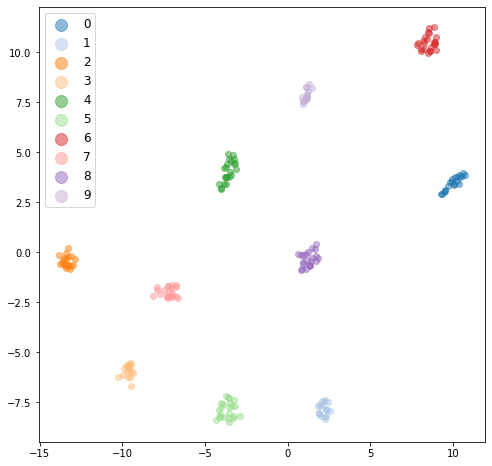

In [84]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# To Get only the correct data prediction  

In [85]:
def get_correct_embeddings(temb_test_embeddings_copy,dataset_full2_copy,test_targets_copy,test_predictions_copy):
    c=0
    print(len(temb_test_embeddings_copy))
    for i in range(len(temb_test_embeddings_copy)):
        try:
            if test_targets_copy[i]!=test_predictions_copy[i]:
                print(i)
                temb_test_embeddings_copy=np.delete(temb_test_embeddings_copy,i-c,axis=0)
                dataset_full2_copy=np.delete(dataset_full2_copy,i-c,axis=0)
                test_targets_copy=np.delete(test_targets_copy,i-c,axis=0)
                test_predictions_copy=np.delete(test_predictions_copy,i-c,axis=0)
                c=c+1
        except:
            print("")
    print(len(temb_test_embeddings_copy))
    return temb_test_embeddings_copy,dataset_full2_copy,test_targets_copy,test_predictions_copy
print(len(temb_test_embeddings_copy))

200


In [86]:
test_embeddings=temb_test_embeddings_copy
dataset_full2=dataset_full2_copy
test_targets=test_targets_copy
dataset_train_original2=dataset_full2

In [87]:
all_lists,all_data_points=all_list(test_embeddings,test_targets,dataset_full2)

(16, 10) 22 10


In [88]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [89]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(test_embeddings) 
kmeans.labels_

array([4, 6, 5, 6, 9, 3, 5, 3, 8, 4, 7, 4, 4, 4, 8, 4, 3, 1, 6, 3, 0, 9,
       9, 5, 8, 4, 2, 0, 7, 4, 7, 3, 9, 9, 7, 6, 5, 5, 1, 2, 6, 0, 0, 8,
       2, 0, 6, 9, 2, 5, 6, 9, 8, 1, 1, 1, 3, 9, 6, 7, 7, 4, 1, 1, 4, 3,
       1, 5, 3, 1, 3, 7, 7, 5, 4, 4, 3, 0, 1, 2, 4, 5, 6, 3, 4, 1, 2, 5,
       5, 0, 7, 1, 6, 7, 0, 0, 5, 9, 9, 1, 2, 3, 3, 2, 8, 3, 7, 8, 4, 6,
       4, 2, 3, 7, 4, 2, 7, 3, 8, 4, 9, 1, 3, 8, 2, 7, 5, 2, 6, 6, 6, 0,
       2, 3, 5, 9, 7, 7, 1, 6, 2, 9, 9, 9, 5, 7, 8, 1, 3, 9, 4, 2, 5, 2,
       2, 2, 6, 1, 2, 4, 0, 5, 4, 7, 7, 8, 8, 2, 5, 8, 1, 9, 1, 3, 9, 6,
       8, 0, 5, 0, 1, 3, 3, 7, 7, 0, 7, 5, 9, 3, 0, 4, 0, 6, 8, 5, 8, 4,
       5, 6])

In [90]:
len(kmeans.cluster_centers_)

10

In [91]:
all_clusters=kmeans.cluster_centers_

In [92]:
import math
import scipy.spatial as sp
import numpy as np
def get_dist(a,b):
    reslt=sp.distance.cosine(a,b)
    return reslt

In [93]:
len(test_embeddings)

200

# assign center point for each class 

In [94]:
center_classes=[]
for clas in all_lists:
    for cluster in all_clusters:
        p=cluster
        n = len(clas)
        dist = math.inf #(infinity)
        temb_test_embeddings=clas#.copy()
        for i in range(n):
            d = get_dist(p,temb_test_embeddings[i])
            if d<dist and d!=0: # to avoid the same point
                dist =d
                np1= temb_test_embeddings[i]
    center_classes.append(np1)
    indx=np.where(all_clusters==cluster)
    all_clusters=np.delete(all_clusters,indx[0][0],axis=0)
    print(len(all_clusters))
len(center_classes)

9
8
7
6
5
4
3
2
1
0


10

# get 10 neighbours for each class to perform (200 initial points)

In [95]:
points_class0=[]
points_class1=[]
points_class2=[]
points_class3=[]
points_class4=[]
points_class5=[]
points_class6=[]
points_class7=[]
points_class8=[]
points_class9=[]
all_points=[]
all_points.append(points_class0)
all_points.append(points_class1)
all_points.append(points_class2)
all_points.append(points_class3)
all_points.append(points_class4)
all_points.append(points_class5)
all_points.append(points_class6)
all_points.append(points_class7)
all_points.append(points_class8)
all_points.append(points_class9)


points_dist0=[]
points_dist1=[]
points_dist2=[]
points_dist3=[]
points_dist4=[]
points_dist5=[]
points_dist6=[]
points_dist7=[]
points_dist8=[]
points_dist9=[]
all_dist=[]
all_dist.append(points_dist0)
all_dist.append(points_dist1)
all_dist.append(points_dist2)
all_dist.append(points_dist3)
all_dist.append(points_dist4)
all_dist.append(points_dist5)
all_dist.append(points_dist6)
all_dist.append(points_dist7)
all_dist.append(points_dist8)
all_dist.append(points_dist9)

In [97]:
all_np=[]
for lab in range(10):
    p=center_classes[lab]
    n = len(all_lists[lab])
    dist = math.inf #(infinity)
    temb_test_embeddings=all_lists[lab]#kmeans.labels_
    try:
        for c in range(10): 
            n = len(temb_test_embeddings)
            dist = math.inf
            for i in range(n):
                d = get_dist(p,temb_test_embeddings[i])
                if d<dist and d!=0: # to avoid the same point
                    dist =d
                    np1= temb_test_embeddings[i]
            all_np.append(np1)
            indx=np.where(temb_test_embeddings==np1)
            print(len(temb_test_embeddings))
            temb_test_embeddings=np.delete(temb_test_embeddings,indx[0][0],axis=0)
            dataset_train_original2=np.delete(dataset_train_original2,indx[0][0],axis=0)
    
        
        n = len(temb_test_embeddings)
        dist = math.inf
        for i in range(n):
            d = get_dist(p,temb_test_embeddings[i])
            all_points[lab].append(all_data_points[lab][i])
            all_dist[lab].append(d)
    except:
        print('No data')
len(all_np)

20
19
18
17
16
15
14
13
12
11
No data
19
18
17
16
15
14
13
12
11
10
No data
19
18
17
16
15
14
13
12
11
10
No data
16
15
14
13
12
11
10
9
8
7
No data
22
21
20
19
18
17
16
15
14
13
No data
23
22
21
20
19
18
17
16
15
14
No data
23
22
21
20
19
18
17
16
15
14
No data
20
19
18
17
16
15
14
13
12
11
No data
22
21
20
19
18
17
16
15
14
13
No data
16
15
14
13
12
11
10
9
8
7
No data


100

# get the original images (as core_data) corrosponding to the 100 center points

In [98]:
indx=np.where(test_embeddings==all_np[0])
core_data1=dataset_full2[indx[0][0]]
core_data1,t=random_split([core_data1],[1,0])
core_data1=tuple(core_data1)
for point in all_np[1:]: 
    indx=np.where(test_embeddings==point)
    arr=dataset_full2[indx[0][0]]
    arr,t=random_split([arr],[1,0])
    arr=tuple(arr)
    core_data1=torch.utils.data.ConcatDataset([arr,core_data1])

In [99]:
core_data=core_data1
len(core_data)

100

# Embeddings of 100 core-set

In [100]:
test_embeddings2,test_targets2,test_predictions2,final_test_acc2=prepare_test_embeddings(core_data)

In [101]:
test_embeddings2,core_data,test_targets2,test_predictions2=get_correct_embeddings(test_embeddings2,core_data,test_targets2,test_predictions2)

100
100


# visualize the ditribution of 100 core_data 

In [102]:
tsne = TSNE(2, verbose=1)
tsne_proj_core = tsne.fit_transform(test_embeddings2)
#tsne_proj = tsne.fit_transform(core_data.datasets[1])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 11.404267
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.629562
[t-SNE] KL divergence after 1000 iterations: 0.053791


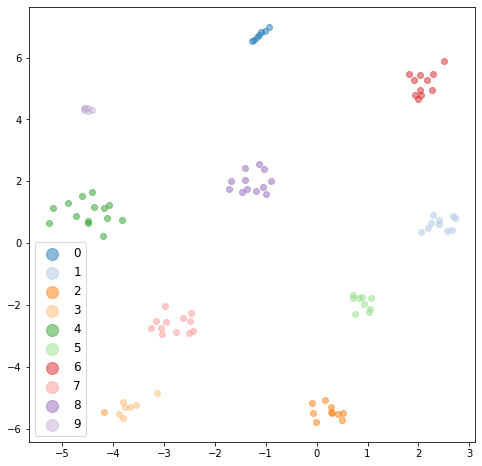

In [103]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets2==lab
    ax.scatter(tsne_proj_core[indices,0],tsne_proj_core[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

### **For one class SVM**

In [104]:
all_lists,_=all_list(test_embeddings2,test_targets2,core_data)

(6, 10) 12 10


In [105]:
X_train=np.concatenate((all_lists[9],all_lists[8],all_lists[7],all_lists[6],all_lists[5],all_lists[4],all_lists[3],all_lists[2],all_lists[1],all_lists[0]),axis=0)
len(X_train)

100

In [106]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.05, kernel = 'rbf', gamma = 'scale').fit(X_train)

In [107]:
def do_predict(data):
    #model=my_model
    #transform = transforms.Compose([transforms.ToTensor()])
    #data=dataset_train
    dataloader = DataLoader(data, batch_size=32)
    #test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 10), dtype=torch.float32)
    #c=0
    #print(len(dataloader))
    for x,y in dataloader:
     #   print(c)
        #c=c+1
     #   x = x.cpu()
        embeddings, logits = model(x)#orig_model(x)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        test_predictions.extend(predicted_class.detach().cpu().tolist())
        test_targets.extend(y.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        #test_embeddings = torch.cat((test_embeddings, embeddings), 0)
      #  test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
        #print('Y',y.detach().cpu().tolist())
    #test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    #print(test_predictions == test_targets)
    test_acc = np.sum(test_predictions == test_targets)
    final_test_acc = test_acc/len(test_embeddings)
    
    return final_test_acc,test_targets,test_embeddings

In [108]:
dataset_full2 = tuple([tuple(e) for e in dataset_full2])
len(dataset_full2)

200

# Just to visualize outlier prediction (Take one example)

In [109]:
dd1,remaning = random_split(dataset_full2, [100,len(dataset_full2)-100])
# do prediction 
_,t_targets3,t_embeddings3=do_predict(dd1)

In [110]:
len(dd1)

100

In [111]:
prediction = one_class_svm.predict(t_embeddings3)
prediction = [1 if i==-1 else 0 for i in prediction]

In [112]:
all_prediction=prediction

# visualization of OneSvm 

In [113]:
core_data=tuple([tuple(e) for e in core_data])

In [114]:
#temb_training=torch.utils.data.ConcatDataset([core_data,temb_training])#core_data
test_embeddings4,test_targets4,_,_=prepare_test_embeddings(core_data)
print(len(test_embeddings4))

100


In [115]:
#do predict on one SVM
prediction2 = one_class_svm.predict(test_embeddings4)
# Change the anomalies' values to make it consistent with the true values
prediction2 = [1 if i==-1 else 0 for i in prediction2]
#print("The result of outlier is ",prediction)

In [116]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings4)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 11.404267
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.520058
[t-SNE] KL divergence after 900 iterations: 0.053089


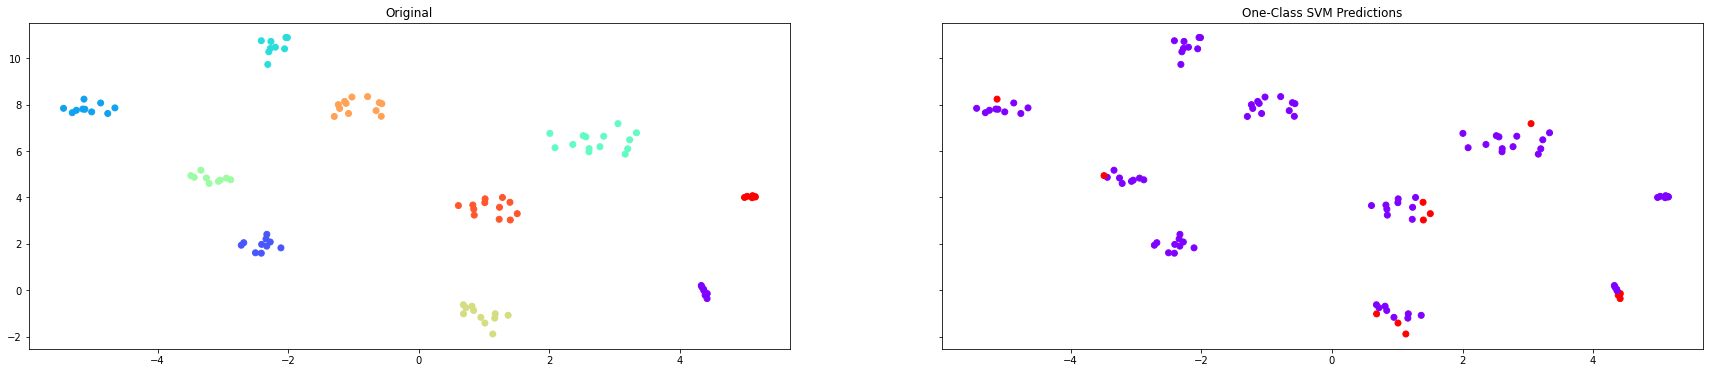

In [117]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(tsne_proj, columns=['feature1', 'feature2'])
df_test['y_test'] = test_targets4#test_targets4
df_test['one_class_svm_prediction'] = prediction2


df_core = pd.DataFrame(tsne_proj_core, columns=['feature1', 'feature2'])
df_core['y_test'] = test_targets2

fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(30,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')


# start iterations 

In [118]:
data_test = MNIST(".", train=False, download=True, transform=transform)

In [119]:
_,_,_,final_test_acc=prepare_test_embeddings(data_test)

In [120]:
final_test_acc

0.9043

In [121]:
dataset_full2_copy=remaining
dataset_train=dataset_train_original#core_data

In [122]:
import time
start_time = time.time()
CNN_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.001005411148071289 seconds ---


In [123]:
pred_list_val=[]
pred_list_train=[]
pred_list_test=[]
all_outliers=[]
len_outliers=[]
Times=[]

In [124]:
_,_,_,final_test_acc=prepare_test_embeddings(data_test)
pred_list_test.append(final_test_acc)

In [125]:
#pred_list_val.append(trainer.callback_metrics["val_acc"])
#pred_list_train.append(trainer.callback_metrics["train_acc"])
pred_list_test.append(final_test_acc)
Times.append(CNN_time)
len_outliers.append(200)

In [126]:
remaining=dataset_full2_copy

In [127]:
len(remaining)

59800

In [128]:
one_class_svm = OneClassSVM(nu=0.0005, kernel = 'poly', gamma ='auto').fit(test_embeddings)

# give an outlier score for all 49800 unlabeled training data and then take the highest 100 points in each round

In [129]:
kernel = 'poly'
gamma = 'auto'
NU=0.00001

roud=0
nu_out=100
while len(dataset_train)<1700:
#for c in range(2):
    start_time = time.time()
    #one_class_svm = OneClassSVM(nu=0.5, kernel = 'rbf', gamma = 'scale').fit(X_train)
    _,_,test_embeddings=do_predict(remaining)
    whole_prediction=one_class_svm.predict(test_embeddings)
    Scores=one_class_svm.score_samples(test_embeddings)
    len_out=0
    for out1 in whole_prediction:
        if out1==1:
            len_out=len_out+1
    print(len_out)
    df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
    df_remaining.sort_values(by=['Score'], inplace=True,ascending=True)
    Whole_outliers=torch.utils.data.ConcatDataset([[],[]])
    
    #if roud>=4:
    #    nu_out=100
    for i in range(nu_out):
        Whole_outliers=torch.utils.data.ConcatDataset([[(df_remaining['Remaining'][i][0],df_remaining['Remaining'][i][1])]
                                                   ,Whole_outliers])
        indx=np.where(test_embeddings==df_remaining['embeddings'][i])
        #print(indx)
        remaining=np.delete(remaining,indx[0][0],axis=0)
    remaining=tuple([tuple(e) for e in remaining])
    remaining=torch.utils.data.ConcatDataset([remaining,[]])
    
    dataset_train=torch.utils.data.ConcatDataset([Whole_outliers,dataset_train])
    print('All Remaining',len(remaining))
    #print('dataset_train_temp>>>>>>>>',len(dataset_train_temb))
    
    train_dl = DataLoader(dataset_train, batch_size=8, shuffle=True)
    #model.setup(dataset_train,dataset_val,stage='fit')
    #model.dataset_val=dataset_val
    #trainer = pl.Trainer(
    #                     max_epochs=20,
    #                     progress_bar_refresh_rate=10,
    #                     callbacks=[checkpoint_callback, embedding_callback])#gpus=1,
    trainer.fit(model,train_dl)
    
    print('Gooooood their is valuable data')
    len_outliers.append(100)


    #print(len(outlier),'......',i)
    #print(trainer.callback_metrics["val_acc"])
    #pred_list_val.append(trainer.callback_metrics["val_acc"])
    #pred_list_train.append(trainer.callback_metrics["train_acc"])

    
    _,_,_,final_test_acc=prepare_test_embeddings(data_test)
    pred_list_test.append(final_test_acc)
    # repeat one SVM
    #prepaire the new test_embeddings


    test_embeddings,test_targets,_,_=prepare_test_embeddings(dataset_train)
    print(len(test_embeddings),final_test_acc)
    
    one_class_svm = OneClassSVM(nu=NU, kernel = kernel, gamma =gamma).fit(test_embeddings)
    CNN_time = time.time() - start_time
    print("--- %s seconds ---" % (time.time() - start_time))
    Times.append(CNN_time)
    roud=roud+1

41983


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 59700


Validation sanity check: 0it [00:00, ?it/s]

Training: 24it [00:00, ?it/s]

Gooooood their is valuable data
300 0.9014
--- 745.6334125995636 seconds ---
54646


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 59600


Validation sanity check: 0it [00:00, ?it/s]

Training: 37it [00:00, ?it/s]

Gooooood their is valuable data
400 0.8957
--- 717.179477930069 seconds ---
56990


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 59500


Validation sanity check: 0it [00:00, ?it/s]

Training: 49it [00:00, ?it/s]

Gooooood their is valuable data
500 0.9271
--- 716.5464527606964 seconds ---
56898


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 59400


Validation sanity check: 0it [00:00, ?it/s]

Training: 62it [00:00, ?it/s]

Gooooood their is valuable data
600 0.9298
--- 729.033441066742 seconds ---
57694


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 59300


Validation sanity check: 0it [00:00, ?it/s]

Training: 74it [00:00, ?it/s]

Gooooood their is valuable data
700 0.9172
--- 738.1368401050568 seconds ---
58389


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 59200


Validation sanity check: 0it [00:00, ?it/s]

Training: 87it [00:00, ?it/s]

Gooooood their is valuable data
800 0.9428
--- 742.246572971344 seconds ---
58766


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 59100


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

Gooooood their is valuable data
900 0.9429
--- 750.6128590106964 seconds ---
58637


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 59000


Validation sanity check: 0it [00:00, ?it/s]

Training: 112it [00:00, ?it/s]

Gooooood their is valuable data
1000 0.9275
--- 762.3509418964386 seconds ---
57946


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58900


Validation sanity check: 0it [00:00, ?it/s]

Training: 124it [00:00, ?it/s]

Gooooood their is valuable data
1100 0.953
--- 776.3208286762238 seconds ---
57432


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58800


Validation sanity check: 0it [00:00, ?it/s]

Training: 137it [00:00, ?it/s]

Gooooood their is valuable data
1200 0.9524
--- 779.0998435020447 seconds ---
58207


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58700


Validation sanity check: 0it [00:00, ?it/s]

Training: 149it [00:00, ?it/s]

Gooooood their is valuable data
1300 0.9465
--- 816.3011789321899 seconds ---
58151


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58600


Validation sanity check: 0it [00:00, ?it/s]

Training: 162it [00:00, ?it/s]

Gooooood their is valuable data
1400 0.9445
--- 810.2476787567139 seconds ---
58402


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58500


Validation sanity check: 0it [00:00, ?it/s]

Training: 174it [00:00, ?it/s]

Gooooood their is valuable data
1500 0.9592
--- 809.6715528964996 seconds ---
58061


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58400


Validation sanity check: 0it [00:00, ?it/s]

Training: 187it [00:00, ?it/s]

Gooooood their is valuable data
1600 0.9513
--- 809.0495681762695 seconds ---
58143


<ipython-input-129-ac251957f6ae>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58300


Validation sanity check: 0it [00:00, ?it/s]

Training: 199it [00:00, ?it/s]

Gooooood their is valuable data
1700 0.9417
--- 824.5110352039337 seconds ---


In [ ]:
all_data=[pred_list_test[:],len_outliers[:],Times[:]]
all_info=pd.DataFrame(all_data)
all_info=all_info.T
all_info.columns=['Test ACC','Length of outliers','Time']
all_info

In [131]:
all_info.to_csv('Result of (AL with ResNet) over MNIST.csv')